In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import casadi as ca
import casadi.tools as ct

In [17]:
def problem_data():
    """ Problem data, numeric constants,...
    """

    data = {}
    data['a'] = 0.5616
    data['b'] = 0.3126
    data['c'] = 48.43
    data['d'] = 0.507
    data['e'] = 55.0
    data['f'] = 0.1538
    data['g'] = 90.0
    data['h'] = 0.16
    data['M'] = 20.0
    data['C'] = 4.0
    #data['UA2'] = 6.84
    data['Cp'] = 0.07
    data['lam'] = 38.5
    data['lams'] = 36.6
    data['F1'] = 10.0
    data['X1'] = 5.0
    data['F3'] = 50.0
    data['T1'] = 40.0
    data['T200'] = 25.0

    return data

def intermediate_vars(x, u, data):

    """ Intermediate model variables
    """

    data['T2'] = data['a']*x['P2'] + data['b']*x['X2'] + data['c']
    data['T3'] = data['d']*x['P2'] + data['e']
    data['T100'] = data['f']*u['P100'] + data['g'] # added noise
    data['UA1'] = data['h']*(data['F1']+data['F3'])
    data['Q100'] = data['UA1']*(data['T100'] - data['T2'])
    data['F100'] = data['Q100']/data['lams']
    data['Q200'] = x['UA2']*(data['T3']-data['T200'])/(1.0 + x['UA2']/(2.0*data['Cp']*u['F200']))
    data['F5'] = data['Q200']/data['lam']
    data['F4'] = (data['Q100']-data['F1']*data['Cp']*(data['T2']-data['T1']))/data['lam']
    data['F2'] = (data['F1'] - data['F4'])
    return data

def intermediate_vars_noisy(x, u, data):

    """ Intermediate model variables
    """
    # Add noise to X1, F2, T1, T200
    data['X1'] += u['X1_noise']
    data['T1'] += u['T1_noise']
    data['T200'] += u['T200_noise']

    data['T2'] = data['a']*x['P2'] + data['b']*x['X2'] + data['c']
    data['T3'] = data['d']*x['P2'] + data['e']
    data['T100'] = data['f']*u['P100'] + data['g'] # added noise
    data['UA1'] = data['h']*(data['F1']+data['F3'])
    data['Q100'] = data['UA1']*(data['T100'] - data['T2'])
    data['F100'] = data['Q100']/data['lams']
    data['Q200'] = x['UA2']*(data['T3']-data['T200'])/(1.0 + x['UA2']/(2.0*data['Cp']*u['F200']))
    data['F5'] = data['Q200']/data['lam']
    data['F4'] = (data['Q100']-data['F1']*data['Cp']*(data['T2']-data['T1']))/data['lam']
    data['F2'] = (data['F1'] - data['F4'])
    data['F2'] += u['F2_noise']
    return data

In [18]:
def dynamics(x, u, data):

    """ System dynamics function (discrete time)
    """

    # state derivative expression
    xdot = ca.vertcat(
        (data['F1']*data['X1'] - data['F2']*x['X2'])/data['M'],
        (data['F4'] - data['F5'])/data['C'],
        0
        )

    # create ode for integrator
    ode = {'x':x, 'p':u,'ode': xdot}

    return [ca.integrator('F','collocation',ode,{'tf':1}), ode]

def vars():

    """ System states and controls
    """

    x = ct.struct_symMX(['X2','P2','UA2'])
    u = ct.struct_symMX(['P100','F200'])

    return x, u

def vars_noisy():

    """ System states and controls
    """

    x = ct.struct_symMX(['X2','P2'])
    u = ct.struct_symMX(['P100','F200','X1_noise','F2_noise','T1_noise','T200_noise'])

    return x, u

def objective(x, u, data):

    """ Economic objective function
    """
    
    # cost definition
    obj = 10.09*(data['F2']+data['F3']) + 600.0*data['F100'] + 0.6*u['F200']

    return ca.Function('economic_cost',[x,u],[obj])

def constraints(x, u, data):
    
    """ Path inequality constraints function (convention h(x,u) >= 0)
    """

    constr = ca.vertcat(
        x['X2'] - 25.0,
        x['P2'] - 40.0,
        100.0 - x['X2'],
        80.0 - x['P2'],
        400.0 - u['P100'],
        400.0 - u['F200'],
    )

    return ca.Function('h', [x,u], [constr])

In [19]:
# set-up system
x, u = vars()
data = intermediate_vars(x, u, problem_data())
f = dynamics(x, u, data)[0]
l = objective(x, u, data)
h = constraints(x, u, data)
# set-up noisy system
# x, u_noisy = vars_noisy()
# data_noisy = intermediate_vars_noisy(x, u_noisy, problem_data())
# f_noisy = dynamics(x, u_noisy, data_noisy)[0]
# l_noisy = objective(x, u_noisy, data_noisy)
# h_noisy = constraints(x, u_noisy, data_noisy)

In [20]:
res = f(x0=x, p=u)
x_next = res['xf'] # Access x_next as the DAE symbolic solution
# Define function F to simplify mapping between symbolic (x,u) --> (x_next)
F = ca.Function('F',[x,u],[x_next],['x','u'],['x_next'])
jacobian_matrix = ca.jacobian(F(x, u), ca.vertcat(x, u))
# Create a function to evaluate the Jacobian
compute_jacobian = ca.Function('compute_jacobian', [x, u], [jacobian_matrix])

# Define values for x and u
x_value = [25.0, 49.743, 6.84]
u_value = [0.01, 0.01]#[191.713, 215.888]

# Evaluate the Jacobian at the specified values of x and u
result = compute_jacobian(x_value, u_value)

print("Jacobian Matrix at x =", x_value, "and u =", u_value, "is:")
print(result)

# res_noisy = f_noisy(x0=x, p=u_noisy)
# x_next_noisy = res_noisy['xf']
# F_noisy = ca.Function('F_noisy',[x,u_noisy],[x_next_noisy],['x','u_noisy'],['x_next'])

Jacobian Matrix at x = [25.0, 49.743, 6.84] and u = [0.01, 0.01] is:

[[0.583422, -0.11919, 9.3229e-10, 0.0304231, 0.00311555], 
 [-0.0157573, 0.964562, -1.47587e-08, 0.00904435, -0.0493211], 
 [00, 00, 1, 00, 00]]


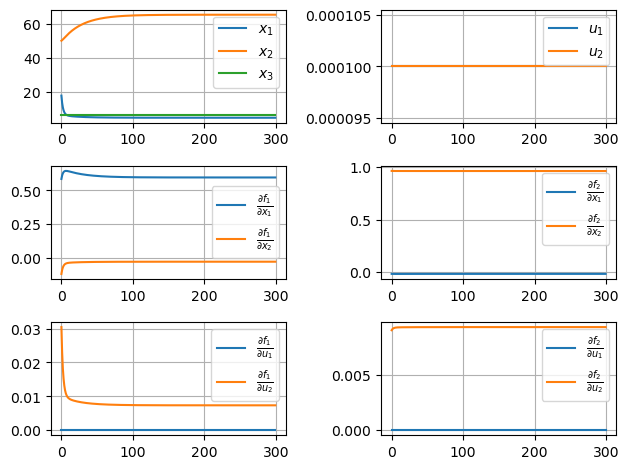

In [21]:
# Simulation parameters
T = 300
Ts = 1
x_s = [25.0, 49.743, 6.84]
u_s = [1e-4, 1e-4]#[191.713, 215.888]

X_log = np.empty((3,0))
X_J_log_f1x1 = np.zeros(T)
X_J_log_f1x2 = np.zeros(T)
X_J_log_f2x1 = np.zeros(T)
X_J_log_f2x2 = np.zeros(T)
X_J_log_f1u1 = np.zeros(T)
X_J_log_f1u2 = np.zeros(T)
X_J_log_f2u1 = np.zeros(T)
X_J_log_f2u2 = np.zeros(T)
U_log = np.empty((2,0))

x_0 = np.array(x_s)
u_0 = np.array(u_s)

for i in range(300):
    # print(i)
    s = x_0
    a = u_0
    
    s_next = F(s, a)
    
    # Compute partial derivative of F with respect to x1 at current time step
    jacobian_value = compute_jacobian(s, a)

    x_0 = np.array(s_next).flatten()

    U_log = np.column_stack((U_log, a[:2]))
    X_log = np.column_stack((X_log, x_0))
    X_J_log_f1x1[i] = jacobian_value[0,0]  # Extract the derivative with respect to x1
    X_J_log_f1x2[i] = jacobian_value[0,1]
    X_J_log_f2x1[i] = jacobian_value[1,0]
    X_J_log_f2x2[i] = jacobian_value[1,1]
    X_J_log_f1u1[i] = jacobian_value[0,2]  # Extract the derivative with respect to x1
    X_J_log_f1u2[i] = jacobian_value[0,3]
    X_J_log_f2u1[i] = jacobian_value[1,2]
    X_J_log_f2u2[i] = jacobian_value[1,3]

plt.subplot(321)    
plt.plot(X_log[0,:], label="$x_1$")
plt.plot(X_log[1,:], label="$x_2$")
plt.plot(X_log[2,:], label="$x_3$")
plt.legend()
plt.grid()

plt.subplot(322)    
plt.plot(U_log[0,:], label="$u_1$")
plt.plot(U_log[1,:], label="$u_2$")
plt.legend()
plt.grid()

plt.subplot(323)
plt.plot(X_J_log_f1x1, label=r"$\frac{\partial f_1}{\partial x_1}$")
plt.plot(X_J_log_f1x2, label=r"$\frac{\partial f_1}{\partial x_2}$")
plt.legend()
plt.grid()

plt.subplot(324)
plt.plot(X_J_log_f2x1, label=r"$\frac{\partial f_2}{\partial x_1}$")
plt.plot(X_J_log_f2x2, label=r"$\frac{\partial f_2}{\partial x_2}$")
plt.legend()
plt.grid()

plt.subplot(325)
plt.plot(X_J_log_f1u1, label=r"$\frac{\partial f_1}{\partial u_1}$")
plt.plot(X_J_log_f1u2, label=r"$\frac{\partial f_1}{\partial u_2}$")
plt.legend()
plt.grid()

plt.subplot(326)
plt.plot(X_J_log_f2u1, label=r"$\frac{\partial f_2}{\partial u_1}$")
plt.plot(X_J_log_f2u2, label=r"$\frac{\partial f_2}{\partial u_2}$")
plt.legend()
plt.grid()

plt.tight_layout()

#plt.savefig("../fig/jacobians_ss.pdf")

In [22]:
X_log[2,:]

array([6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84,
       6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.84, 6.

In [130]:
T = 300
Ts = 1
N = 10
x_s = [25.0, 49.743]
u_s = [191.713, 215.888]
# Test steady state validity
print(F(x_s, u_s))
x = ca.MX.sym('x')
u = ca.MX.sym('u')

[25, 49.743]


[17.92, 49.9811]
[13.6737, 50.3235]
[11.026, 50.7224]
[9.3333, 51.1504]
[8.23203, 51.5906]
[7.50509, 52.0331]
[7.01836, 52.4716]
[6.68712, 52.9021]
[6.45711, 53.3225]
[6.29334, 53.7313]
[6.17311, 54.128]
[6.08169, 54.5122]
[6.0095, 54.8838]
[5.9503, 55.2432]
[5.90004, 55.5903]
[5.85607, 55.9257]
[5.81666, 56.2495]
[5.78067, 56.5622]
[5.74734, 56.864]
[5.71618, 57.1554]
[5.68682, 57.4367]
[5.65904, 57.7081]
[5.63264, 57.9702]
[5.60751, 58.223]
[5.58353, 58.4671]
[5.56064, 58.7027]
[5.53875, 58.93]
[5.51781, 59.1494]
[5.49777, 59.3611]
[5.47857, 59.5654]
[5.46019, 59.7625]
[5.44257, 59.9528]
[5.42568, 60.1364]
[5.40948, 60.3136]
[5.39395, 60.4845]
[5.37904, 60.6495]
[5.36475, 60.8087]
[5.35102, 60.9623]
[5.33785, 61.1105]
[5.3252, 61.2536]
[5.31306, 61.3916]
[5.3014, 61.5247]
[5.29019, 61.6532]
[5.27943, 61.7772]
[5.26908, 61.8968]
[5.25914, 62.0122]
[5.24959, 62.1236]
[5.2404, 62.231]
[5.23157, 62.3347]
[5.22308, 62.4347]
[5.21492, 62.5312]
[5.20706, 62.6243]
[5.19951, 62.7142]
[5.19224

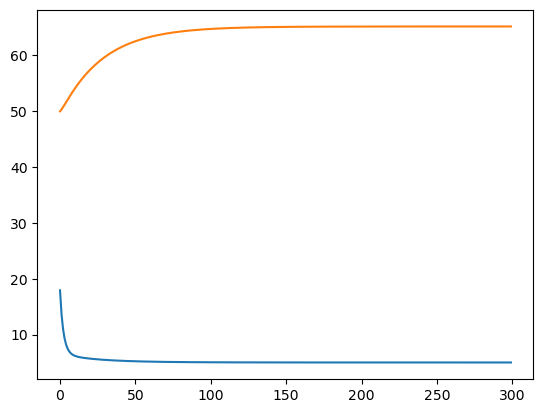

In [131]:
X_log = np.empty((2,0))
U_log = np.empty((2,0))

x_0 = np.array(x_s)
u_0 = np.array(u_s)

for i in range(300):
    # print(i)
    s = x_0
    a = [0.01, 0.01]
    
    s_next = F(s, a)
    
    print(s_next)

    x_0 = np.array(s_next).flatten()

    U_log = np.column_stack((U_log, a[:2]))
    X_log = np.column_stack((X_log, x_0))
    
plt.plot(X_log[0,:])
plt.plot(X_log[1,:])

In [26]:
t = np.arange(0,T,Ts)
u = 10*np.random.randn(*t.shape, 2)

In [27]:
x_0 = np.array(x_s)
perturbation = 0.5
x_0 = x_0# * (1 + perturbation*np.random.uniform(-1,1))
x_0.shape

(2,)

In [73]:
X_log = np.empty((2,0))
U_log = np.empty((2,0))

x_0 = np.array(x_s)
u_0 = np.array(u_s)

noisy = False

for i in range(300):
    # print(i)
    s = x_0
    a = u[i,:]
    
    if noisy:
        a = ca.vertcat(a,
               np.random.normal(loc=.0, scale=1),
               np.random.normal(loc=.0, scale=2),
               np.random.normal(loc=.0, scale=8),
               np.random.normal(loc=.0, scale=5))
        s_next = F_noisy(s, a)
    else:
        s_next = F(s, a)

    x_0 = np.array(s_next).flatten()

    U_log = np.column_stack((U_log, a[:2]))
    X_log = np.column_stack((X_log, x_0))
    
plt.plot(X_log[0,:])
plt.plot(X_log[1,:])

F([25, 49.743], u[0, 0]){0}


Exception: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.